In [10]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy
import matplotlib.patches as mpatches

In [11]:
sns.set_style("darkgrid")

INIT_COL = sns.color_palette('colorblind')[0]
RESP_COL = sns.color_palette('colorblind')[1]

ID = "0605"
figure_path = "figs" + os.sep + ID + os.sep

if not os.path.exists(figure_path):
    os.makedirs(figure_path)


In [12]:
directory = "../results/results_" + ID + "_determineProb_keep"
idx = 0
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if not filename.endswith(".csv"):
        continue
    newdata = pd.read_csv(f, index_col = None)
    if (idx == 0):
        data = newdata
    else:
        data = pd.concat([data, newdata], ignore_index = True)
    idx += 1
    
print("Number of observations: " + str(len(data.index)))
print("Number of observations per group: " + str(len(data.index) / 99))

Number of observations: 98109
Number of observations per group: 991.0


In [13]:
keep_columns = ["init_zeroToMProb", "resp_zeroToMProb", "init_tom", "resp_tom", "init_gain", "resp_gain",
                "resp_highestValueParetoOutcome", "init_highestValueParetoOutcome", "init_canLie", "resp_canLie"]

def apply_data_transformation(data):
    df = copy.deepcopy(data[keep_columns])
    df["zeroToMProb"] = df.apply(lambda x: x["init_zeroToMProb"] if (x["init_tom"] == 0) else x["resp_zeroToMProb"], axis=1)
    df["name"] = df.apply(lambda x: "init_resp" if ((x["init_tom"] == 0) and (x["resp_tom"] == 0)) else ("init" if x["init_tom"] == 0 else "resp"), axis=1)
    
    sub_df = df.loc[(df["name"] == "init_resp")]
    new_row = sub_df.iloc[[0]].copy()
    new_row["name"] = "init"
    new_df = new_row
    new_row = sub_df.iloc[[0]].copy()
    new_row["name"] = "resp"
    new_df = pd.concat([new_df, new_row]).reset_index(drop=True)
    
    for idx in range(1, len(sub_df.index)):
        new_row = sub_df.iloc[[idx]].copy()
        new_row["name"] = "init"
        new_df = pd.concat([new_df, new_row]).reset_index(drop=True)
        new_row["name"] = "resp"
        new_df = pd.concat([new_df, new_row]).reset_index(drop=True)
    df = pd.concat([new_df, df]).reset_index(drop=True)

    df = df.loc[df["name"] != "init_resp"]
    df["gain"] = df.apply(lambda x: x["init_gain"] if x["name"] == "init" else x["resp_gain"], axis=1)
    
    return df


In [14]:
df_transformed = apply_data_transformation(data)

In [15]:
# df_av_total = df_work.groupby(["zeroToMProb"], as_index=False).mean(numeric_only=True)

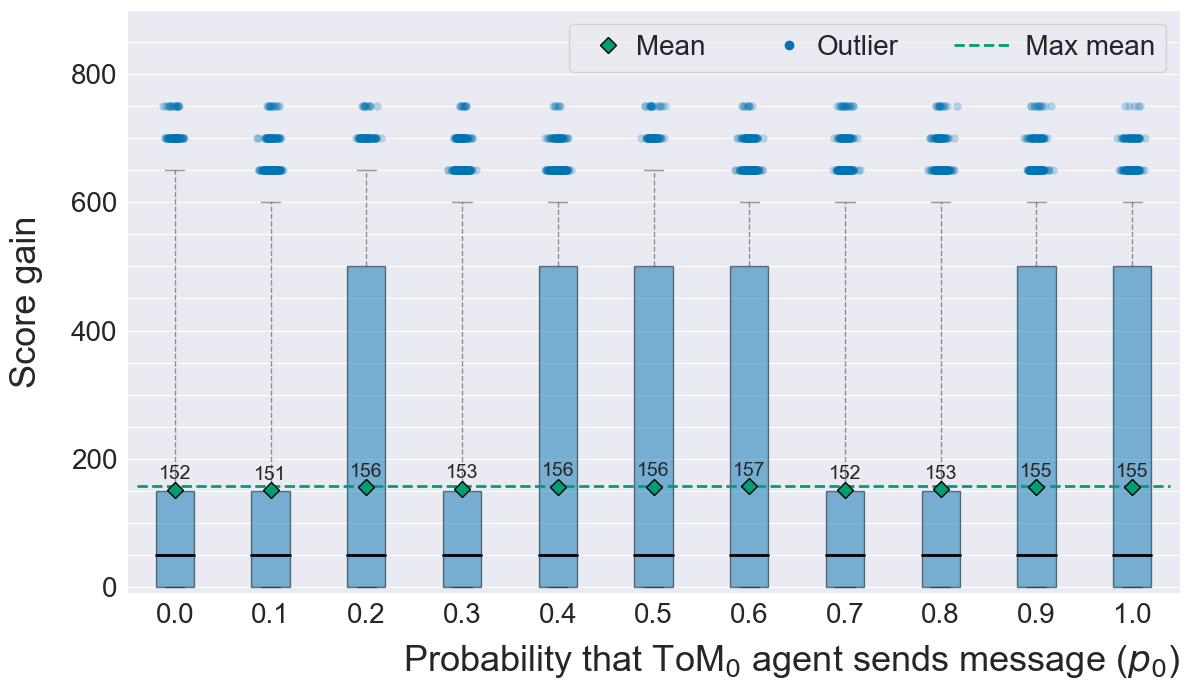

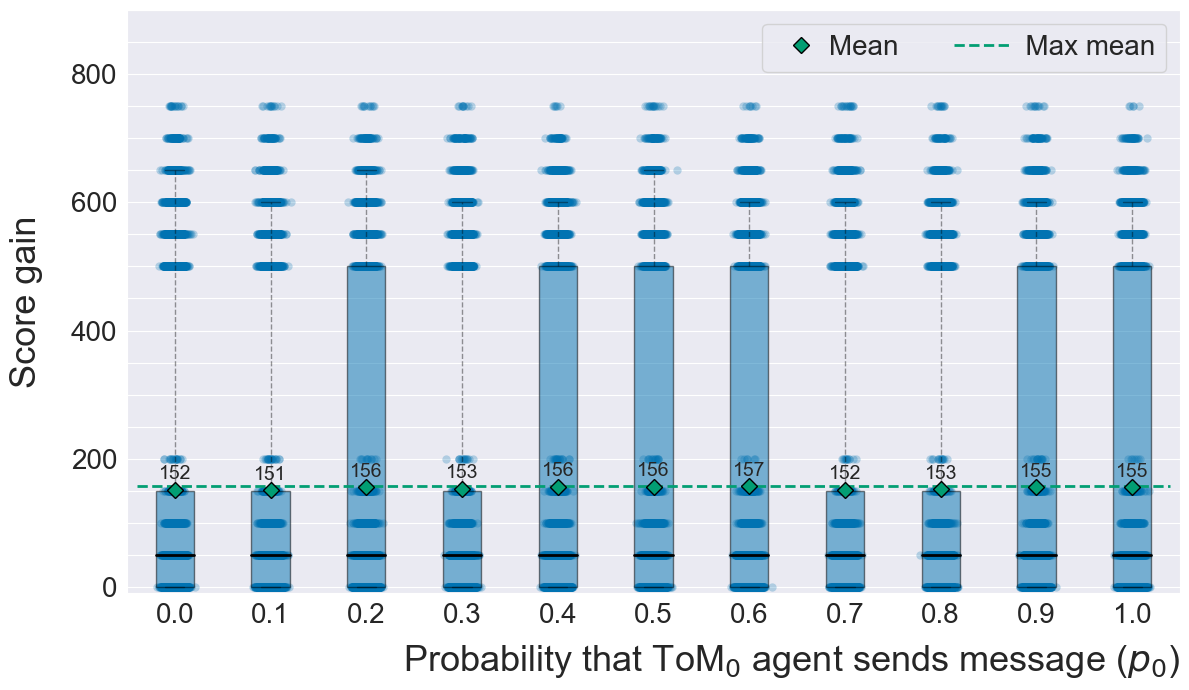

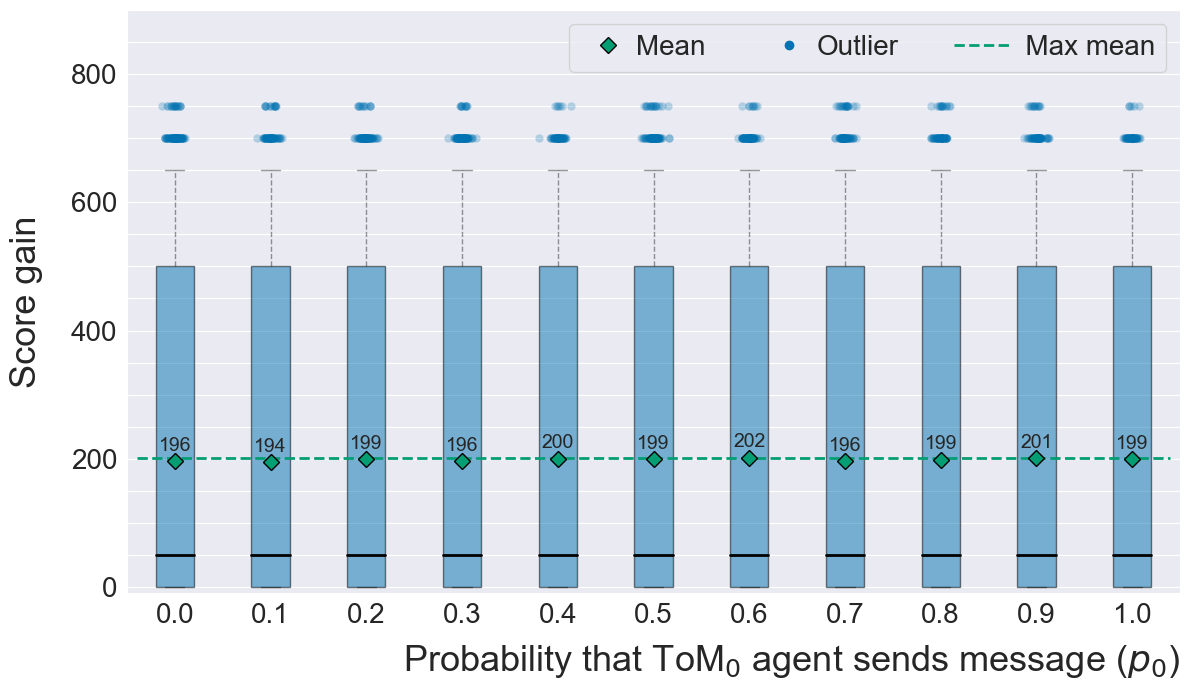

In [24]:
# Figure settings
meanpointprops = dict(marker='D', markeredgecolor='black', markerfacecolor=sns.color_palette('colorblind')[2], markersize=8)
whiskerprops = dict(alpha=0.4, linestyle="dashed")
capprops = dict(alpha=0.4)
medianprops = dict(lw=2, color="black")
boxprops = dict(facecolor=INIT_COL, color="black", alpha=0.5)

BIN_WIDTH = 0.4
TICK_SIZE = 20
VALUE_SIZE = 14
LABEL_SIZE = 26
figsize = (12,7)


def make_box_plot(data, pos, ax, draw_points):
    bp = ax.boxplot(data, patch_artist=True, notch=False, vert=1, showfliers=True, whis=[2.5, 97.5],
                    positions=pos, widths=BIN_WIDTH, showmeans=True, meanprops=meanpointprops,
                    whiskerprops=whiskerprops, medianprops=medianprops, capprops=capprops,
                    boxprops=boxprops)
    
    plt.setp(bp['fliers'][0], color='black', alpha=0)
    
    if draw_points:
        x = np.random.normal(pos[0], 0.05, size=len(data))
        y = data
        ax.scatter(x, y, color=INIT_COL, alpha=0.25, linewidth=0)
    else:
        top_points = bp["fliers"][0].get_data()
        x = np.random.normal(top_points[0], 0.05, size=len(top_points[0]))
        y = top_points[1]
        ax.scatter(x, y, color=INIT_COL, alpha=0.25, linewidth=0)
    
    
def make_plot(data, draw_points):
    fig, ax = plt.subplots(figsize = figsize)
    max_mean = 0

    for i in range(0, 11, 1):
        plot_data = list(data[data["zeroToMProb"] == i/10]["gain"])
        make_box_plot(plot_data, [i], ax, draw_points)
        
        new_val = np.mean(plot_data)
        ax.text(i, new_val+10, round(new_val), size=VALUE_SIZE, ha="center", va='bottom')
        max_mean = np.max([new_val, max_mean])
        
    # Add horizontal line...
    # print(max_mean)
    ax.hlines(y=max_mean, xmin=-BIN_WIDTH, xmax=10 + BIN_WIDTH, linestyles='dashed', label='smt', lw=2, colors=meanpointprops["markerfacecolor"])
        
    handles, _ = ax.get_legend_handles_labels()
    # ax.yaxis.set_tick_params(pad=1.6*max(T.label1.get_window_extent().width for T in ax.yaxis.majorTicks))
    ax.tick_params(axis='both', labelsize=TICK_SIZE)
    ax.set_xticklabels([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_ylim(top=900, bottom=-10)
    if draw_points:
        ax.legend((plt.Line2D([0], [0], color=meanpointprops["markerfacecolor"], marker=meanpointprops["marker"], 
                                markeredgecolor=meanpointprops["markeredgecolor"], markersize=meanpointprops["markersize"], linewidth=0),
                handles[0]),
                ("Mean", "  Max mean"), fontsize=TICK_SIZE, ncol=3, fancybox=True, loc="upper right", handletextpad=0)
    else:
        ax.legend((plt.Line2D([0], [0], color=meanpointprops["markerfacecolor"], marker=meanpointprops["marker"], 
                                markeredgecolor=meanpointprops["markeredgecolor"], markersize=meanpointprops["markersize"], linewidth=0),
                plt.Line2D([0],[0], color=INIT_COL, marker="o", linewidth=0, alpha=1),
                handles[0]),
                ("Mean", "Outlier", "  Max mean"), fontsize=TICK_SIZE, ncol=3, fancybox=True, loc="upper right", handletextpad=0)
    
    ax.xaxis.grid(False, which ="both")
    ax.yaxis.grid(True, which="both")

    ax.set_ylabel("Score gain", fontsize=LABEL_SIZE, labelpad=20)
    ax.set_xlabel(r"Probability that ToM$_0$ agent sends message ($p_0$)", fontsize=LABEL_SIZE, loc="right", labelpad=10)
    fig.tight_layout()
    plt.minorticks_on()

make_plot(df_transformed, False)
plt.savefig(figure_path + "boxplot.pdf")

make_plot(df_transformed, True)
plt.savefig(figure_path + "boxplot_with_points.pdf")

make_plot(df_transformed.loc[(df_transformed["init_highestValueParetoOutcome"] != -1) & (df_transformed["resp_highestValueParetoOutcome"] != -1)],
          False)
plt.savefig(figure_path + "boxplot_pareto.pdf")

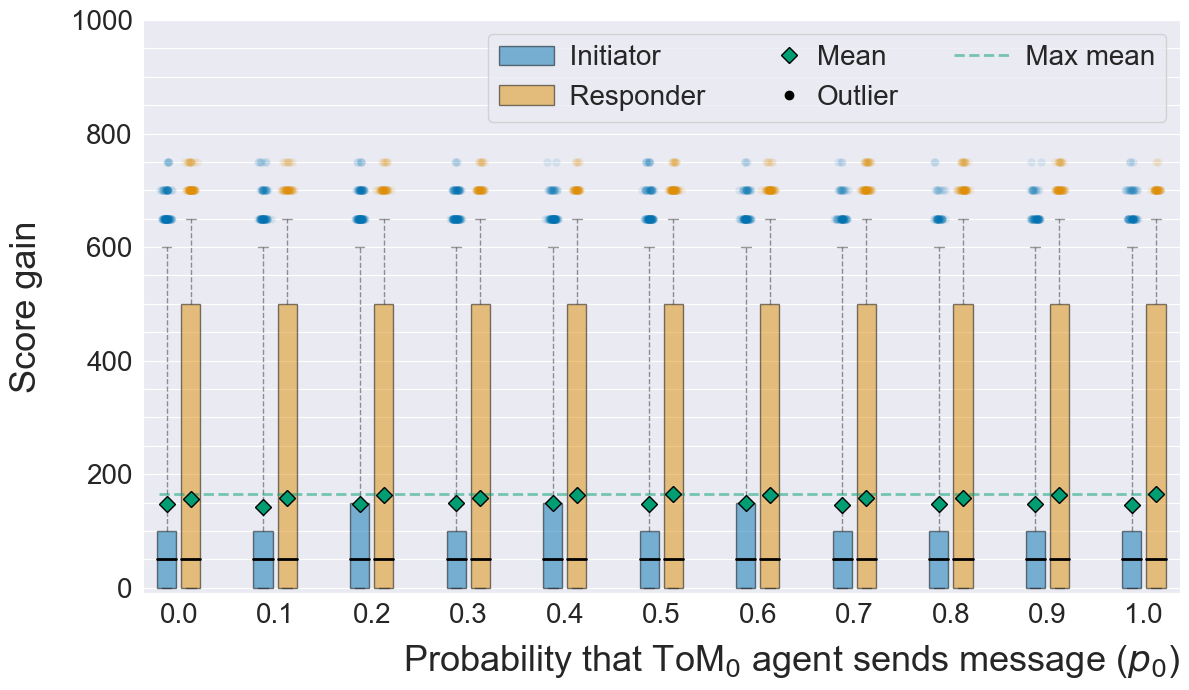

In [17]:
# Figure settings
meanpointprops = dict(marker='D', markeredgecolor='black', markerfacecolor=sns.color_palette('colorblind')[2], markersize=8)
whiskerprops = dict(alpha=0.4, linestyle="dashed")
capprops = dict(alpha=0.4)
medianprops = dict(lw=2, color="black")
boxprops = dict(color="black", alpha=0.5)

BIN_WIDTH = 0.4
TICK_SIZE = 20
LABEL_SIZE = 26
figsize = (12,7)

def make_box_plot_multiple(data, pos, ax):
    bp = ax.boxplot(data, patch_artist=True, notch=False, vert=1, showfliers=True, whis=[2.5, 97.5],
                    positions=pos, widths=BIN_WIDTH, showmeans=True, meanprops=meanpointprops,
                    whiskerprops=whiskerprops, medianprops=medianprops, capprops=capprops,
                    boxprops=boxprops)

    bp['boxes'][0].set(facecolor=INIT_COL)
    bp['boxes'][1].set(facecolor=RESP_COL)
    
    plt.setp(bp['fliers'][0], color='black', alpha=0)
    plt.setp(bp['fliers'][1], color='black', alpha=0)
    
    fill_colors = [INIT_COL, RESP_COL]
    for i in [0,1]:
        top_points = bp["fliers"][i].get_data()
        x = np.random.normal(top_points[0], 0.05, size=len(top_points[0]))
        y = top_points[1]
        ax.scatter(x, y, color=fill_colors[i], alpha=0.1, linewidth=0)

def make_plot_differentiate(data):
    fig, ax = plt.subplots(figsize = figsize)
    max_mean_init = 0
    max_mean_resp = 0

    for i in range(0, 21, 2):
        plot_data = [list(data[(data["zeroToMProb"] == i/20) & (data["name"] == "init")]["gain"]),
                    list(data[(data["zeroToMProb"] == i/20) & (data["name"] == "resp")]["gain"])]
        make_box_plot_multiple(plot_data, [i-0.25, i+0.25], ax)
        
        new_val_init = np.mean(plot_data[0])
        new_val_resp = np.mean(plot_data[1])
        max_mean_init = np.max([new_val_init, max_mean_init])
        max_mean_resp = np.max([new_val_resp, max_mean_resp])
        
    # Add horizontal line...
    ax.hlines(y=np.max([max_mean_init, max_mean_resp]), xmin=-BIN_WIDTH, xmax=20+BIN_WIDTH, linestyles='dashed', label='smt', lw=2, colors=meanpointprops["markerfacecolor"],
              alpha=0.5)
        
    handles, _ = ax.get_legend_handles_labels()
    # ax.yaxis.set_tick_params(pad=1.6*max(T.label1.get_window_extent().width for T in ax.yaxis.majorTicks))
    ax.tick_params(axis='both', labelsize=TICK_SIZE)
    ax.set_xticks(range(0, 21, 2))
    ax.set_xticklabels([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_ylim(top=1000, bottom=-10)
    ax.legend((mpatches.Patch(facecolor=INIT_COL, edgecolor='black', label="Initiator", alpha=boxprops["alpha"]),
            mpatches.Patch(facecolor=RESP_COL, edgecolor='black', label="Responder", alpha=boxprops["alpha"]),
            plt.Line2D([0], [0], color=meanpointprops["markerfacecolor"], marker=meanpointprops["marker"], 
                            markeredgecolor=meanpointprops["markeredgecolor"], markersize=meanpointprops["markersize"], linewidth=0),
            plt.Line2D([],[], color="black", marker="o", markeredgecolor="black", linewidth=0), 
            handles[0]),
                ("  Initiator", "  Responder", "Mean", "Outlier", "  Max mean"), fontsize=TICK_SIZE, ncol=3, fancybox=True, loc="upper right",
                handletextpad=0)
    ax.xaxis.grid(False, which ="both")
    ax.yaxis.grid(True, which="both")

    ax.set_ylabel("Score gain", fontsize=LABEL_SIZE, labelpad=20)
    ax.set_xlabel(r"Probability that ToM$_0$ agent sends message ($p_0$)", fontsize=LABEL_SIZE, loc="right", labelpad=10)
    fig.tight_layout()
    plt.minorticks_on()

make_plot_differentiate(df_transformed)
plt.savefig(figure_path + "boxplot_separate.pdf")

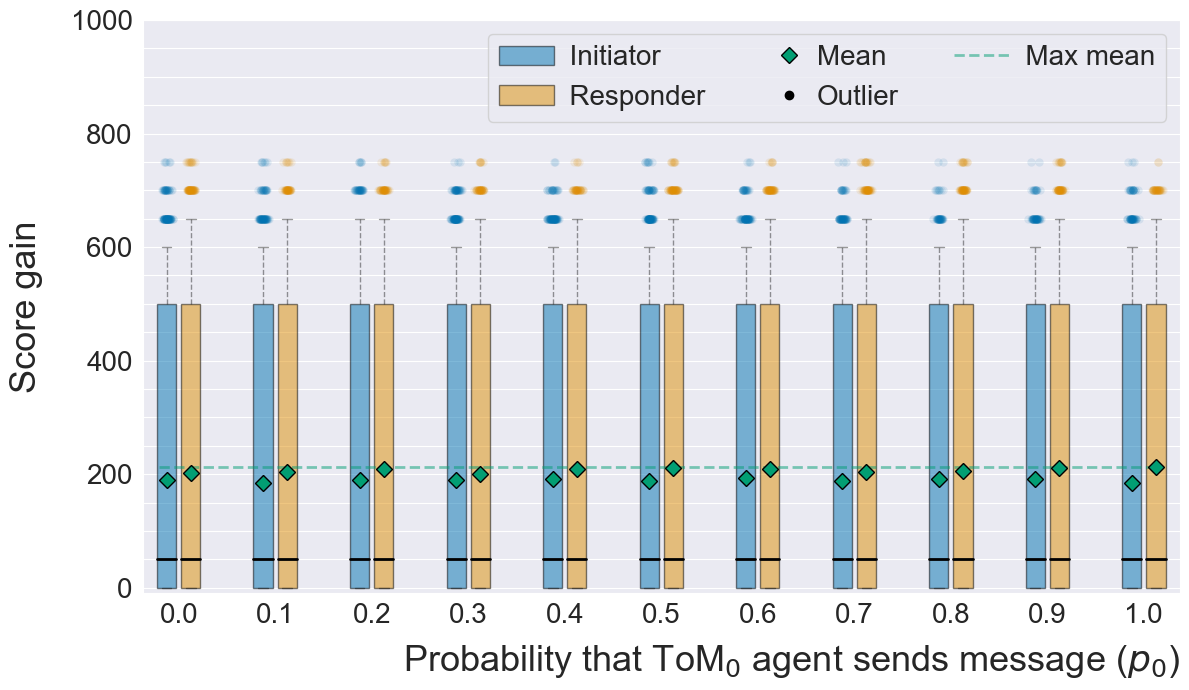

In [18]:
make_plot_differentiate(df_transformed.loc[(df_transformed["init_highestValueParetoOutcome"] != -1) & (df_transformed["resp_highestValueParetoOutcome"] != -1)])
plt.savefig(figure_path + "boxplot_separate_pareto.pdf")